[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34/Pulmo-TS2ONN/blob/main/model/Pulmo-TS2ONN.ipynb)

**Pulmo-TS2ONN: A Novel Triple Scale Self Operational Neural Network for Pulmonary Disorder Detection Using Respiratory Sounds**

**Coder: Arka Roy**

**Github Profile:** **[https://github.com/rsarka34](https://github.com/rsarka34)**

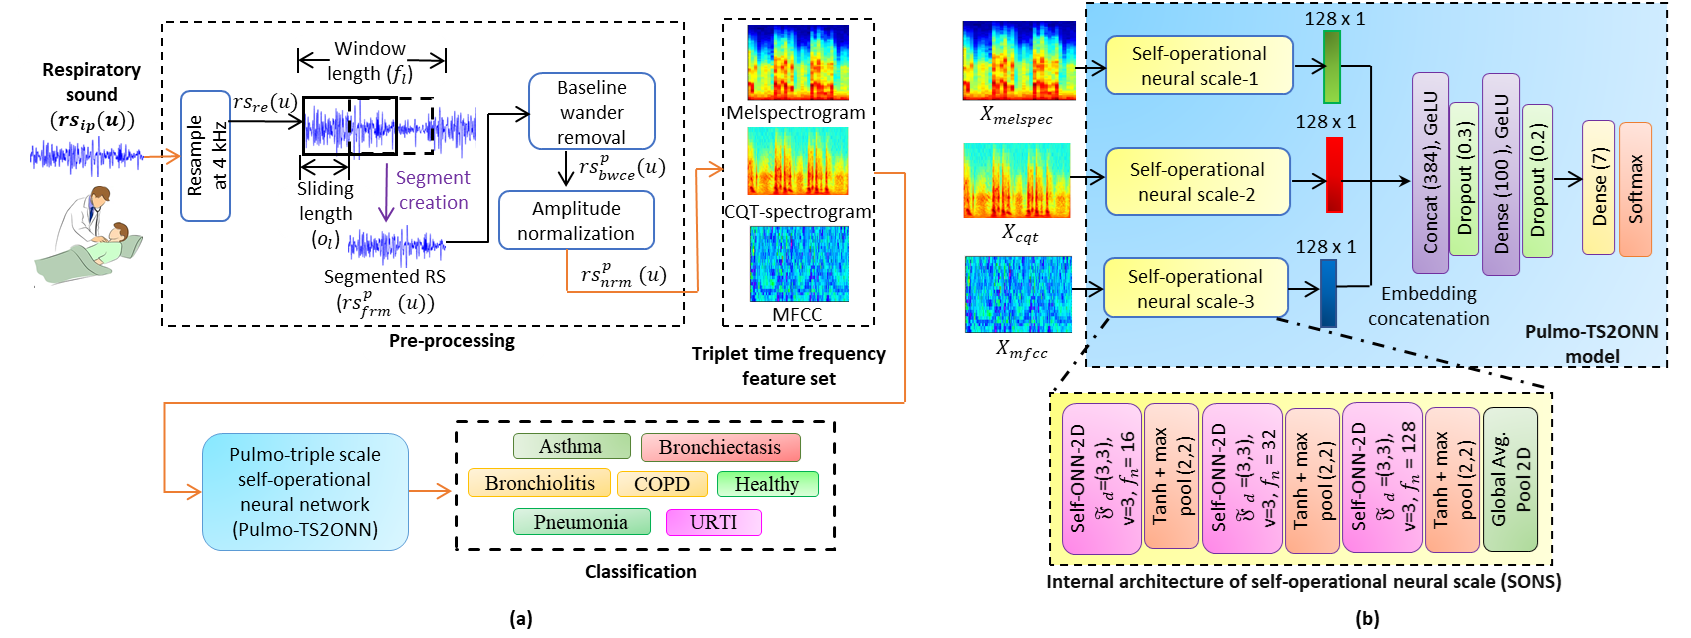

# **Pulmo-TS2ONN**

## **Import libraries**

In [ ]:
!pip install mat73
import mat73
import cv2 as cvlib
import librosa
!pip install pydub
from pydub import AudioSegment
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

Mounted at /content/gdrive


## **Import Signals and Labels**

In [ ]:
sig_dict = mat73.loadmat('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_sig.mat')
sig=sig_dict['all_sig']
print(sig.shape)

(20000, 18905)


In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)
Y.shape

(18905,)

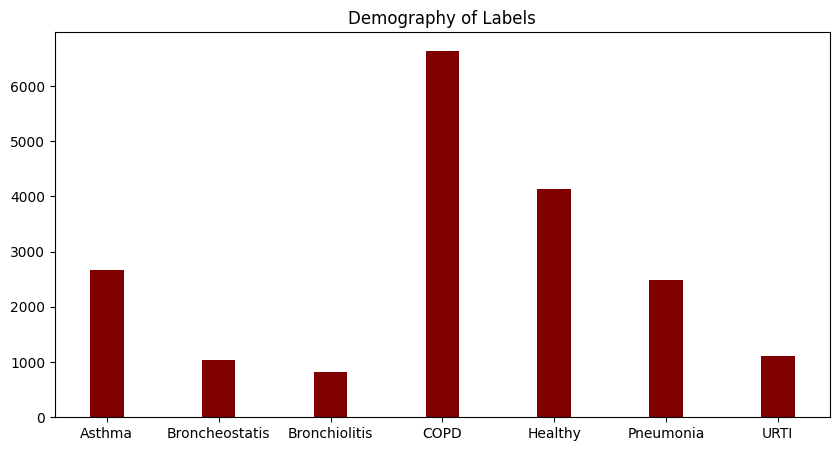

In [ ]:
asth=0;normal=0;bronchio=0;broncheos=0;copd=0;pnue=0;urti=0;

r=18905
for i in range (r):
  d=l[i]
  if d=='Asthma':
    asth=asth+1
  elif d=='Broncheostatis':
    broncheos=broncheos+1
  elif d=='Bronchiolitis':
    bronchio=bronchio+1
  elif d=='COPD':
    copd=copd+1
  elif d=='Healthy':
    normal=normal+1
  elif d=='Pneumonia':
    pnue=pnue+1
  elif d=='URTI':
    urti=urti+1

data = {'Asthma':asth, 'Broncheostatis':broncheos, 'Bronchiolitis':bronchio,
        'COPD':copd, 'Healthy':normal,'Pneumonia':pnue,'URTI':urti}
classes = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(classes, values, color ='maroon',width = 0.3)
plt.title("Demography of Labels")
plt.show()

## ***Extarct three different time frequency representational features:***


1.   Melspectrogram
2.   MFCC
3.   CQT spectrograms



In [ ]:
r=len(sig[1,:])
nfft=1024
win_length=1024
hop_length=410;sr=4000
melspec_list=[];mfcc_list=[]; cqt_list=[];
d_shape=64

import cv2 as cvlib
for i in range (r):
  clip=sig[:,i]
  # melspectrogram
  mel_spec=librosa.feature.melspectrogram(y=clip,sr=4000,n_mels=64,n_fft=1024,hop_length=524,win_length=1024,window='hann')
  log_melspec = librosa.amplitude_to_db(mel_spec)
  norm_melspec=(log_melspec-np.min(log_melspec))/(np.max(log_melspec)-np.min(log_melspec))
  mel_img=np.flip(norm_melspec, 0)
  melspec_list.append(mel_img)
  # mfcc extraction
  mfccs = librosa.feature.mfcc(y=clip, sr=4000, n_mfcc=30)
  mfcc_img=np.flip(mfccs, 0)
  mfcc_list.append(mfccs)
  # CQT extraction
  cqts= np.abs(librosa.cqt(y=clip, sr=4000, hop_length=512, n_bins=64, window='hann', pad_mode='reflect'))
  log_cqt=librosa.amplitude_to_db(cqts)
  norm_cqt=(log_cqt-np.min(log_cqt))/(np.max(log_cqt)-np.min(log_cqt))
  cqt_img=np.flip(norm_cqt, 0)
  cqt_list.append(cqt_img)

melspec_set=np.array(melspec_list)
mfcc_set=np.array(mfcc_list)
cqt_set=np.array(cqt_list)
print('shape of melspectrogram dataset'+str(np.shape(melspec_set)))
print('shape of mfcc dataset'+str(np.shape(mfcc_set)))
print('shape of cqt dataset'+str(np.shape(cqt_set)))

shape of melspectrogram dataset(18905, 64, 39)
shape of mfcc dataset(18905, 30, 40)
shape of cqt dataset(18905, 64, 40)


In [ ]:
import pickle
def pickle_save(location_to_save,dumping_var):
    outfile = open(location_to_save,'wb')
    pickle.dump(dumping_var,outfile)
    outfile.close()
    print('=========done=========')

base_location='/content/gdrive/MyDrive/ARKA/7class_disease_work/'
saving_melspec=base_location+'Melspecs'
saving_mfcc=base_location+'Mfccs'
saving_cqt=base_location+'CQTs'

pickle_save(saving_melspec,melspec_set)
pickle_save(saving_mfcc,mfcc_set)
pickle_save(saving_cqt,cqt_set)

=========done=========
=========done=========
=========done=========


In [ ]:
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt

Melspecs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Melspecs')
Melspecs_re=np.reshape(Melspecs,(Melspecs.shape[0],1,Melspecs.shape[1],Melspecs.shape[2]))
Mfccs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Mfccs')
Mfccs_re=np.reshape(Mfccs,(Mfccs.shape[0],1,Mfccs.shape[1],Mfccs.shape[2]))
CQTs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/CQTs')
CQTs_re=np.reshape(CQTs,(CQTs.shape[0],1,CQTs.shape[1],CQTs.shape[2]))

In [ ]:
print('shape of melspectrogram dataset'+str(np.shape(Melspecs_re)))
print('shape of mfcc dataset'+str(np.shape(Mfccs_re)))
print('shape of cqt dataset'+str(np.shape(CQTs_re)))

shape of melspectrogram dataset(18905, 1, 64, 39)
shape of mfcc dataset(18905, 1, 30, 40)
shape of cqt dataset(18905, 1, 64, 40)


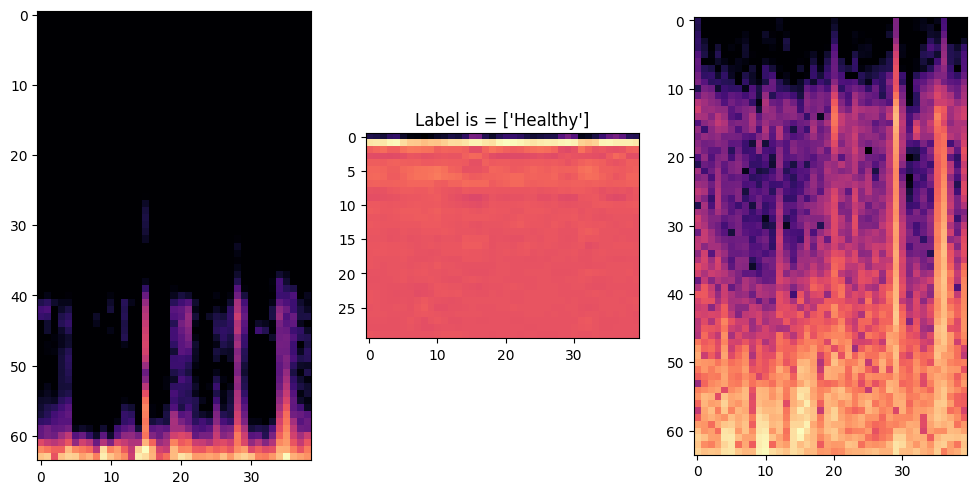

In [ ]:
l=np.array(labels)
idx=15000;
plt.figure(figsize=(12,8))
plt.subplot(131); plt.imshow(Melspecs[idx,:,:], cmap="magma");
plt.subplot(132); plt.imshow(Mfccs[idx,:,:], cmap="magma"); plt.title('Label is = '+str(l[idx]))
plt.subplot(133); plt.imshow(CQTs[idx,:,:], cmap="magma");

In [ ]:
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d

Cloning into 'fastonn'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 178 (delta 32), reused 73 (delta 12), pack-reused 75
Receiving objects: 100% (178/178), 557.58 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached 

/content/fastonn/fastonn/utils/utils.py:347: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if val_rate is 0: return [[np.reshape(np.array([indices]),(len(indices),)),np.array([])]]


In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

136

## ***Data loading helper functions***

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xmfcc,Xcqt, y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmel,Xmfcc,Xcqt, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1,Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmel_test,Xmfcc_test,Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmel_test,Xmfcc_test,Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xmfcc_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xmfcc_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xmfcc_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds


In [ ]:
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl

In [ ]:
bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,Mfccs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1891,)
Creating data loaders with batch size: 128


## **Multiscale Self-organized Operartional Neural Network**

In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(3*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, melspec_data, mfcc_data, cqt_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)
        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)
        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat((x_mel_flat, x_mfcc_flat,x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 30,40),(1, 64, 40)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 28, 38]             448
             Tanh-12           [-1, 16, 28, 38]               0
        MaxPool2d-13           [-1, 16, 14, 19]               0
        SelfONN2d-14           [-1, 32,

## **Training of Pulmo-TS2ONN**

In [ ]:
lr = 0.001
n_epochs = 300
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch,xmfcc_batch,xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch,xmfcc_batch,xcqt_batch = xmel_batch.cuda(),xmfcc_batch.cuda(),xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch,xmfcc_batch,xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val,xmfcc_val,xcqt_val, y_val in (val_dl):
            xmel_val,xmfcc_val,xcqt_val=xmel_val.cuda(),xmfcc_val.cuda(),xcqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val,xmfcc_val,xcqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

In [ ]:
val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

## **Testing of Pulmo-TS2ONN**

(1891,)
Test accuracy is = 98.88947646747752%


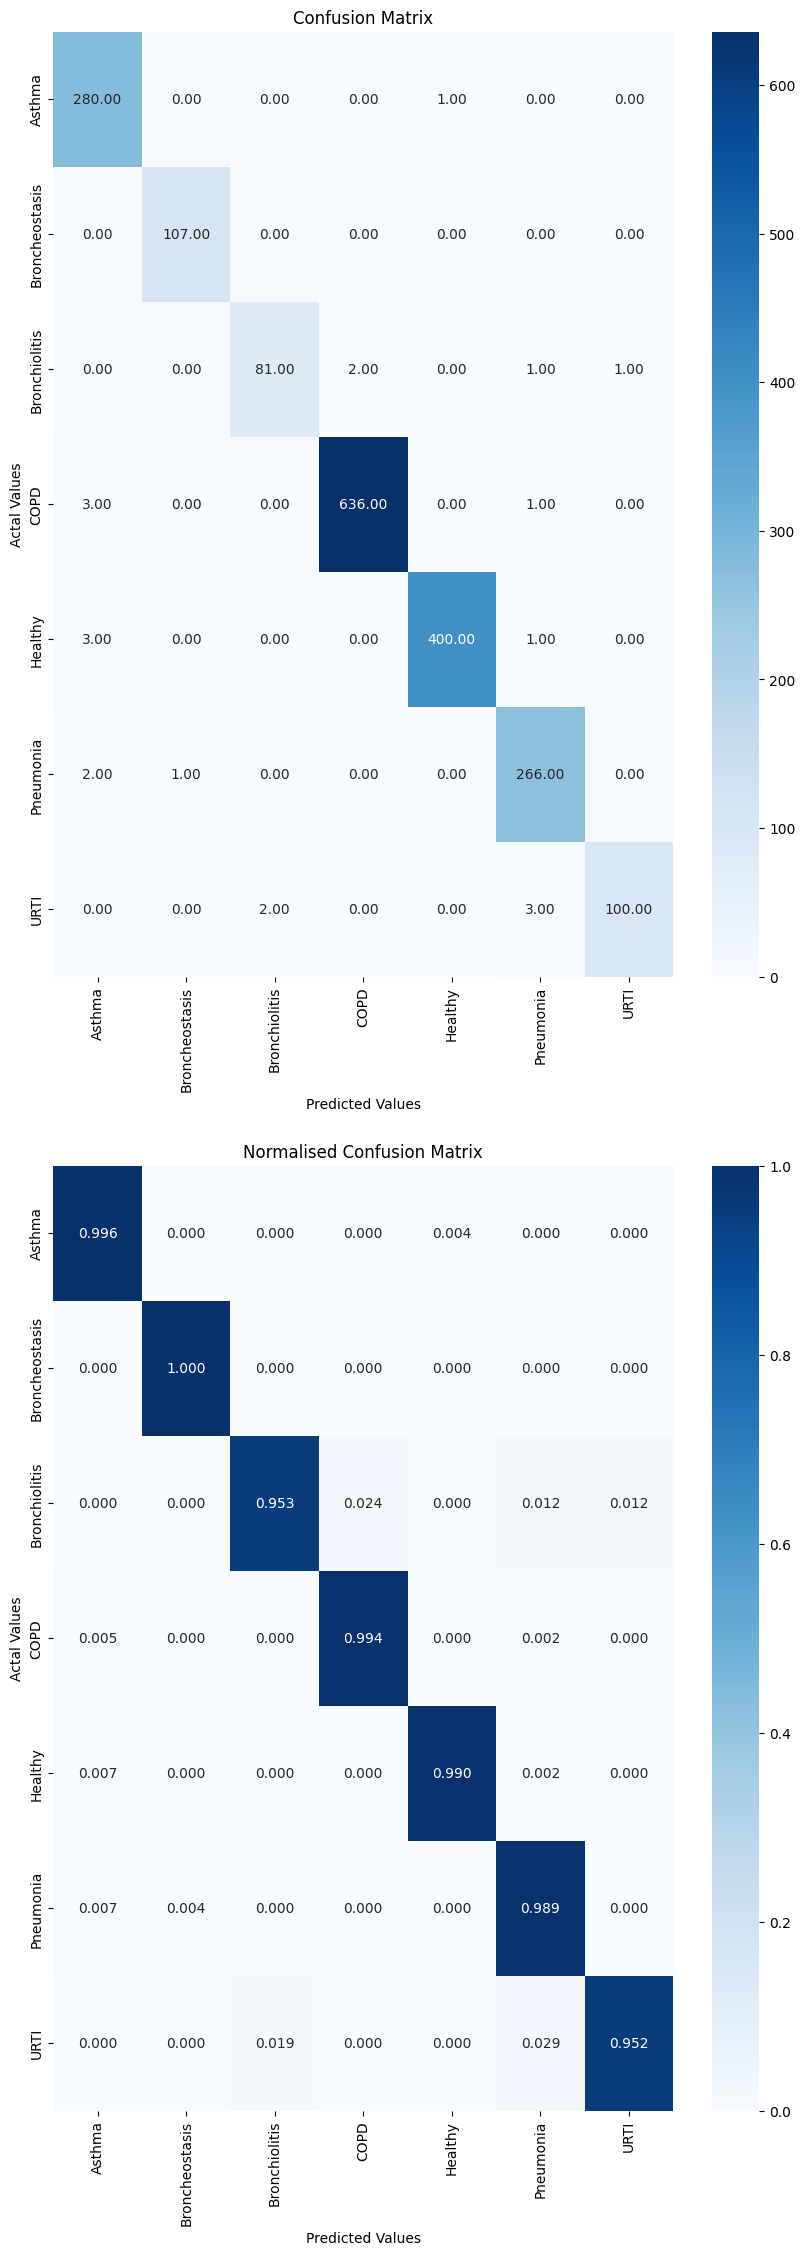

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))

y_true = []
y_pred = []
FEATS=[]
model.eval()
for xmel_test,xmfcc_test,xcqt_test, y_tst in (tst_dl):
    xmel_test,xmfcc_test,xcqt_test=xmel_test.cpu(),xmfcc_test.cpu(),xcqt_test.cpu()
    out_test = model(xmel_test,xmfcc_test,xcqt_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    fea=activation['linear2'].data.cpu().numpy()
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(10,27))
plt.subplot(211)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(212)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues", fmt='.3f')
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# **BA 1: Melspectrogram Model**

Mounted at /content/gdrive
Cloning into 'fastonn'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 171 (delta 30), reused 71 (delta 11), pack-reused 70
Receiving objects: 100% (171/171), 555.71 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299577 sha256=dc04c9f587512786ae385f521a6c63a6a07810bdc9fcc251bd891491a2764e3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6ya0rxc/wheels/61/8b/99/d8de1ae4507a27413aa8596d19e503645ccfdb3df60b239682
Successfully built fastonn


/content/fastonn/fastonn/utils/utils.py:347: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if val_rate is 0: return [[np.reshape(np.array([indices]),(len(indices),)),np.array([])]]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

Text(0.5, 0, 'Epochs')

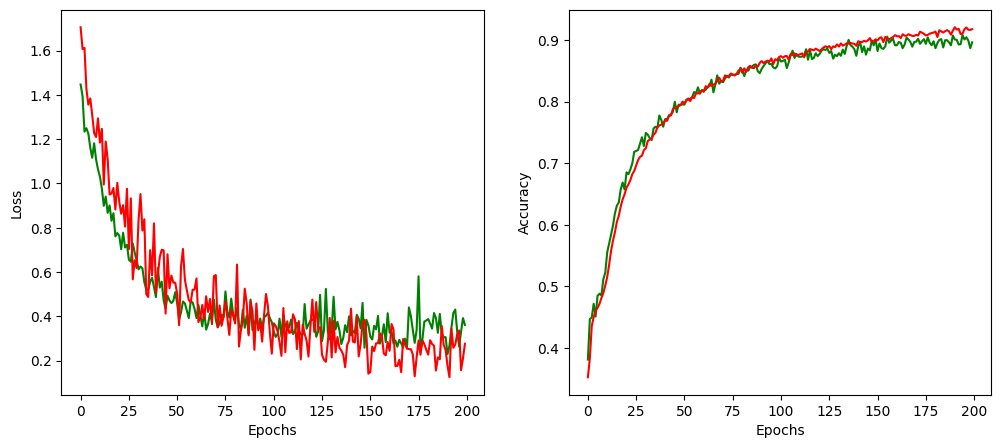

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt
Melspecs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Melspecs')
Melspecs_re=np.reshape(Melspecs,(Melspecs.shape[0],1,Melspecs.shape[1],Melspecs.shape[2]))

labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)

from sklearn.model_selection import train_test_split
def create_datasets(Xmel, Y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, y_train1, y_test = train_test_split(Xmel, Y, test_size=0.1,random_state=seed)

    Xmel_train, Xmel_valid, y_train, y_valid = train_test_split(Xmel_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmel_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmel_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train, y_train)
    valid_ds = TensorDataset(Xmel_valid, y_valid)
    test_ds= TensorDataset(Xmel_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,Y,seed=10)
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, data):
        # melspectrogram scale
        x = self.onnv1(data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x_gap=self.GAP(x)

        x=self.flatten(x_gap)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, (1, 64, 39))

lr = 0.001
n_epochs = 200
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch = xmel_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val, y_val in (val_dl):
            xmel_val=xmel_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for xmel_test, y_tst in (tst_dl):
    xmel_test=xmel_test.cuda()
    out_test = model(xmel_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

from sklearn.metrics import classification_report
target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
print(classification_report(y_true,y_pred, target_names=target_names))

Test accuracy is = 87.62559492332099%


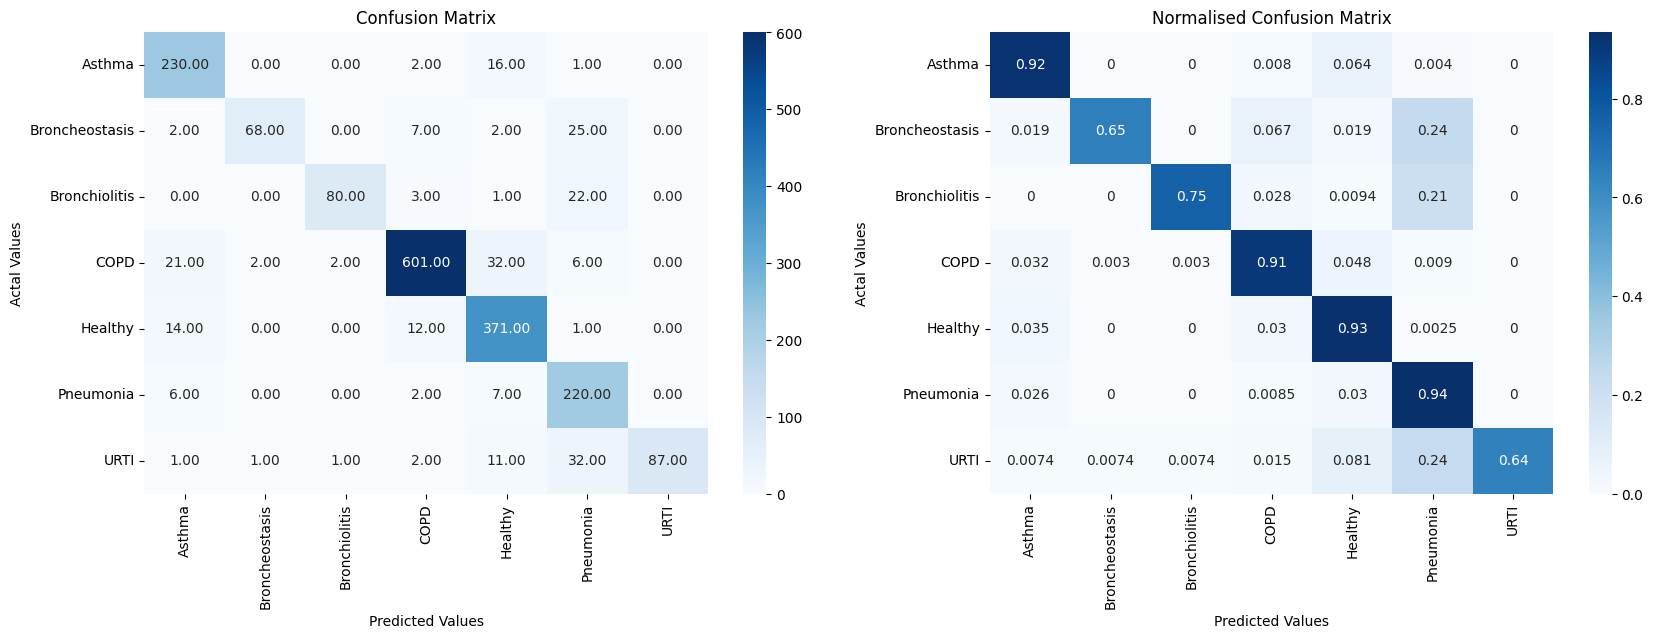

                precision    recall  f1-score   support

        Asthma       0.84      0.92      0.88       249
Broncheostasis       0.96      0.65      0.78       104
 Bronchiolitis       0.96      0.75      0.85       106
          COPD       0.96      0.91      0.93       664
       Healthy       0.84      0.93      0.89       398
     Pneumonia       0.72      0.94      0.81       235
          URTI       1.00      0.64      0.78       135

      accuracy                           0.88      1891
     macro avg       0.90      0.82      0.84      1891
  weighted avg       0.89      0.88      0.88      1891



In [ ]:
new_loc='/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/'
# save the plot varriables
filepath_tloss=new_loc+'/MELSPEC_train_loss_fold.txt'; np.savetxt(filepath_tloss,train_loss)
filepath_vloss=new_loc+'/MELSPEC_val_loss_fold.txt'; np.savetxt(filepath_vloss,val_loss)
filepath_tacc=new_loc+'/MELSPEC_train_acc_fold.txt'; np.savetxt(filepath_tacc,train_acc)
filepath_vacc=new_loc+'/MELSPEC_val_acc_fold.txt'; np.savetxt(filepath_vacc,val_acc)
PATH= '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MELSPEC_model.pt'
torch.save(model, PATH)
torch.save(model.state_dict(), '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MELSPEC_model.pth')

**Create t-SNE**

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'fastonn' already exists and is not an empty directory.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299577 sha256=faccb355456482736c3b6de157ca0bc2fcfe182bf239698e9a8610aa99fcf975
  Stored in directory: /tmp/pip-ephem-wheel-cache-x87x4sjc/wheels/61/8b/99/d8de1ae4507a27413aa8596d19e503645ccfdb3df60b239682
Successfully built fastonn
  Attempting uninstall: fastonn
    Found existing installation: fastonn 0.1.1
    Uninstalling fastonn-0.1.1:
      Successfully uninstalled fastonn-0.1.1


Test accuracy is = 87.62559492332099%


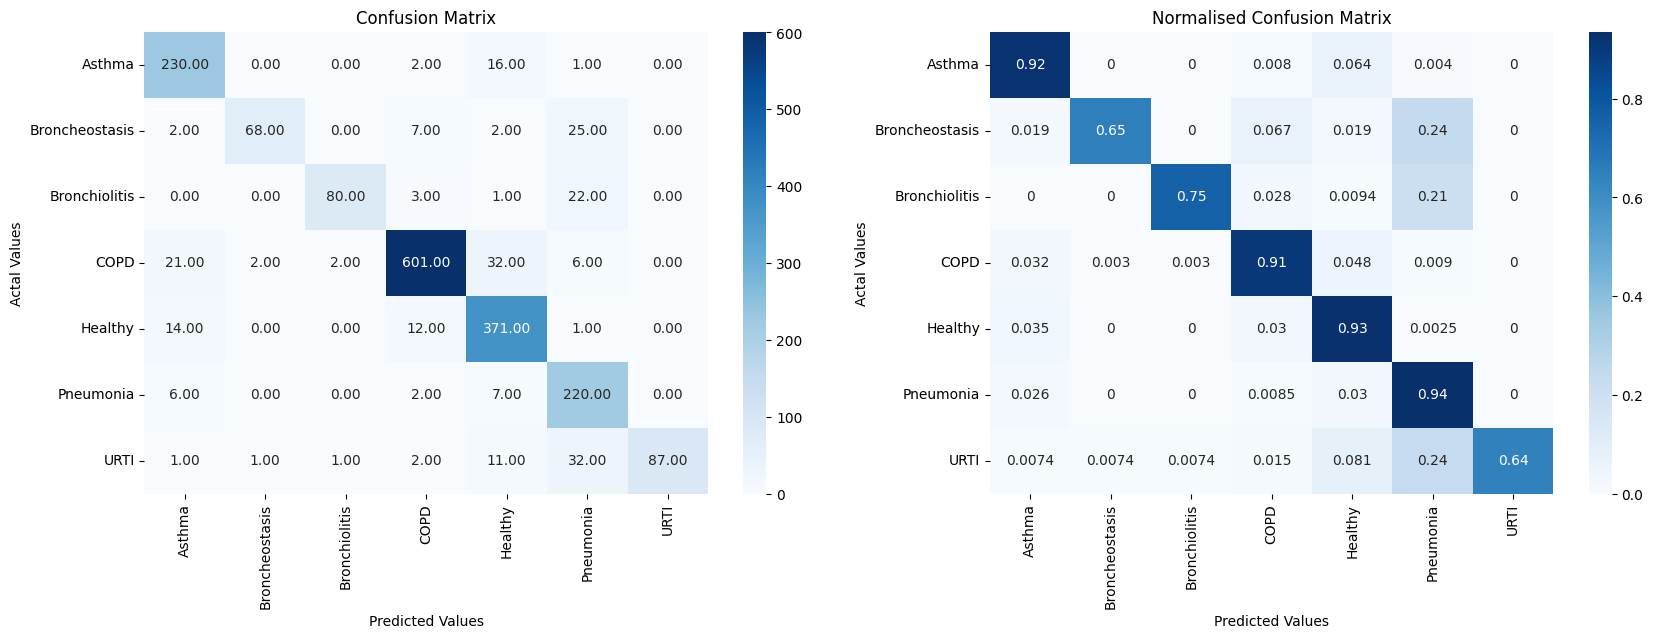

feats shape: (1891, 50)
label shape: (1891,)


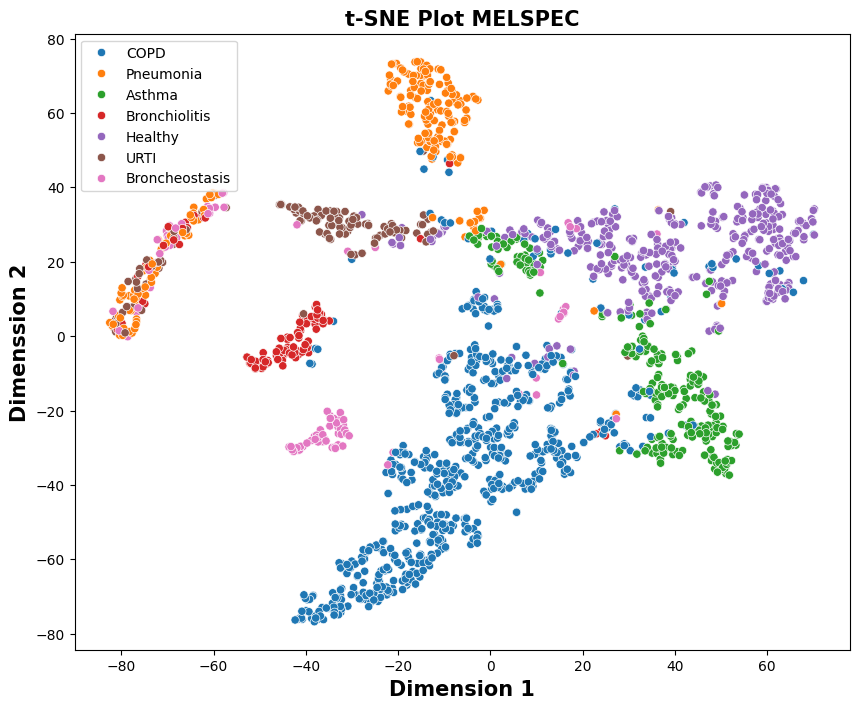

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt
Melspecs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Melspecs')
Melspecs_re=np.reshape(Melspecs,(Melspecs.shape[0],1,Melspecs.shape[1],Melspecs.shape[2]))

labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)

from sklearn.model_selection import train_test_split
def create_datasets(Xmel, Y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, y_train1, y_test = train_test_split(Xmel, Y, test_size=0.1,random_state=seed)

    Xmel_train, Xmel_valid, y_train, y_valid = train_test_split(Xmel_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmel_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmel_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train, y_train)
    valid_ds = TensorDataset(Xmel_valid, y_valid)
    test_ds= TensorDataset(Xmel_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,Y,seed=10)
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, data):
        # melspectrogram scale
        x = self.onnv1(data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x_gap=self.GAP(x)

        x=self.flatten(x_gap)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)

PATH= "/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MELSPEC_model.pt"
model=torch.load(PATH)

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))
y_true = []
y_pred = []
FEATS=[]

for xmel_test, y_tst in (tst_dl):
    xmel_test=xmel_test.cuda()
    out_test = model(xmel_test)
    fea=activation['linear2'].data.cpu().numpy()
    FEATS.append(fea)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)

q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=20.0,learning_rate='auto',init='random',method="exact")
def scatter(x, labels):
    df = pd.DataFrame()
    df["Labels"] = labels
    df["comp-1"] = x[:,0]
    df["comp-2"] =x[:,1]
    plt.figure(figsize=(10,8))
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df)
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)

test_tsne_embeds = tsne.fit_transform(FEATS)
scatter(test_tsne_embeds,Label_ar)
plt.title('t-SNE Plot MELSPEC',fontweight ='bold', fontsize = 15)

np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/Melspec_tsne_emds.txt',test_tsne_embeds)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/Melspec_tsne_labels.txt',Label_ar,'%s')

# **BA 2: MFCC model**

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

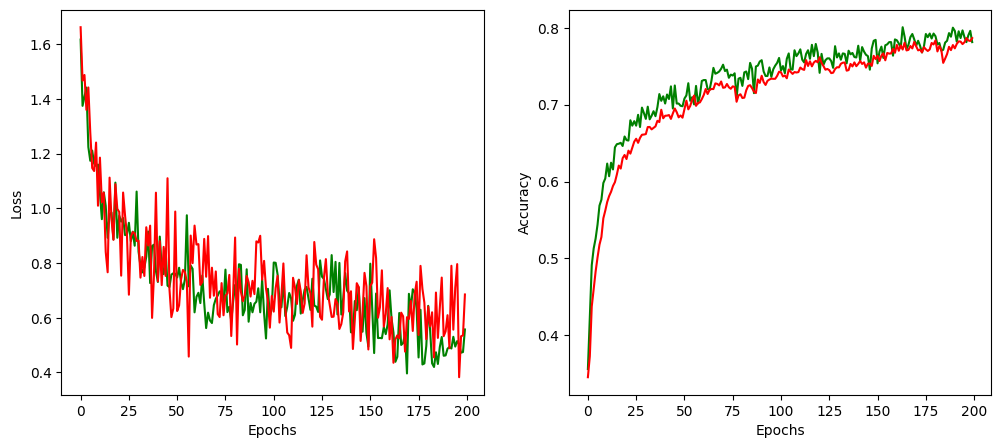

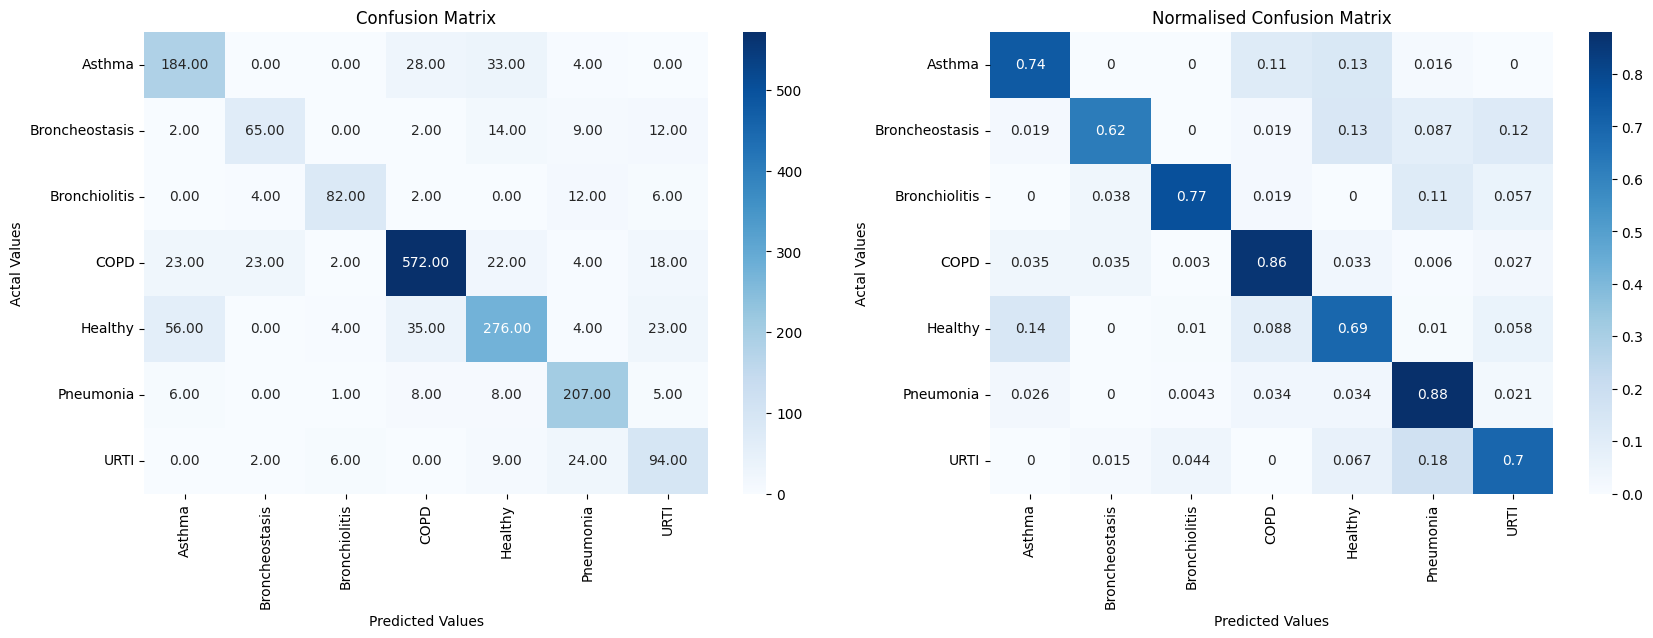

                precision    recall  f1-score   support

        Asthma       0.68      0.74      0.71       249
Broncheostasis       0.69      0.62      0.66       104
 Bronchiolitis       0.86      0.77      0.82       106
          COPD       0.88      0.86      0.87       664
       Healthy       0.76      0.69      0.73       398
     Pneumonia       0.78      0.88      0.83       235
          URTI       0.59      0.70      0.64       135

      accuracy                           0.78      1891
     macro avg       0.75      0.75      0.75      1891
  weighted avg       0.79      0.78      0.78      1891



In [ ]:
import fastonn
from fastonn import SelfONN2d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt
Mfccs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Mfccs')
Mfccs_re=np.reshape(Mfccs,(Mfccs.shape[0],1,Mfccs.shape[1],Mfccs.shape[2]))

labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)

from sklearn.model_selection import train_test_split
def create_datasets(Xmel, Y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, y_train1, y_test = train_test_split(Xmel, Y, test_size=0.1,random_state=seed)

    Xmel_train, xmfcc_valid, y_train, y_valid = train_test_split(Xmel_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, xmfcc_valid,Xmel_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, xmfcc_valid,Xmel_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train, y_train)
    valid_ds = TensorDataset(xmfcc_valid, y_valid)
    test_ds= TensorDataset(Xmel_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
trn_ds, val_ds, tst_ds = create_datasets(Mfccs_re,Y,seed=10)
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, data):
        # melspectrogram scale
        x = self.onnv1(data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x_gap=self.GAP(x)

        x=self.flatten(x_gap)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, (1, 64, 39))

lr = 0.001
n_epochs = 200
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmfcc_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmfcc_batch = xmfcc_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmfcc_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmfcc_val, y_val in (val_dl):
            xmfcc_val=xmfcc_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmfcc_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for xmfcc_test, y_tst in (tst_dl):
    xmfcc_test=xmfcc_test.cuda()
    out_test = model(xmfcc_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

from sklearn.metrics import classification_report
target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
print(classification_report(y_true,y_pred, target_names=target_names))

In [ ]:
PATH= '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MFCC_model.pt'
torch.save(model, PATH)
torch.save(model.state_dict(), '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MFCC_model.pth')

new_loc='/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/'
# save the plot varriables
filepath_tloss=new_loc+'/MFCC_train_loss_fold.txt'; np.savetxt(filepath_tloss,train_loss)
filepath_vloss=new_loc+'/MFCC_val_loss_fold.txt'; np.savetxt(filepath_vloss,val_loss)
filepath_tacc=new_loc+'/MFCC_train_acc_fold_.txt'; np.savetxt(filepath_tacc,train_acc)
filepath_vacc=new_loc+'/MFCC_val_acc_fold.txt'; np.savetxt(filepath_vacc,val_acc)

Test accuracy is = 78.26546800634586%


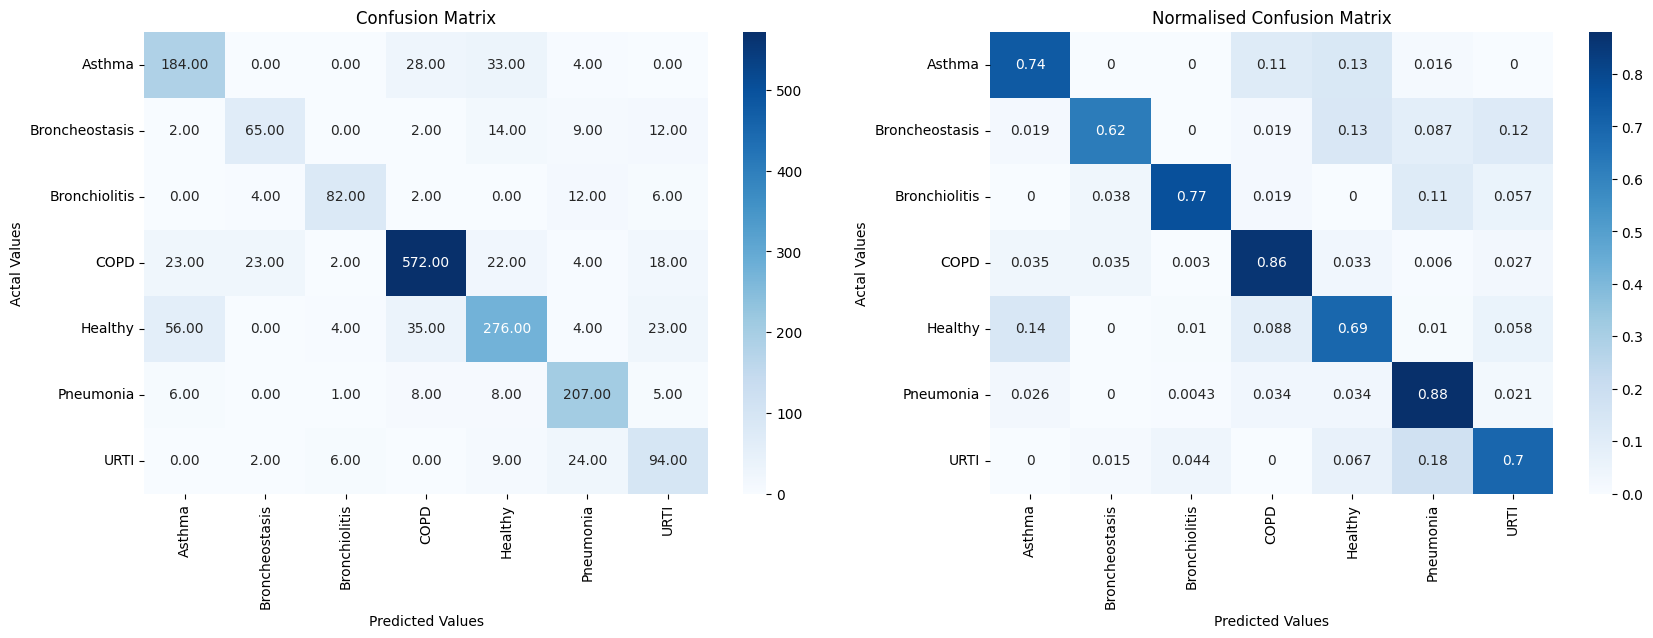

feats shape: (1891, 50)
label shape: (1891,)


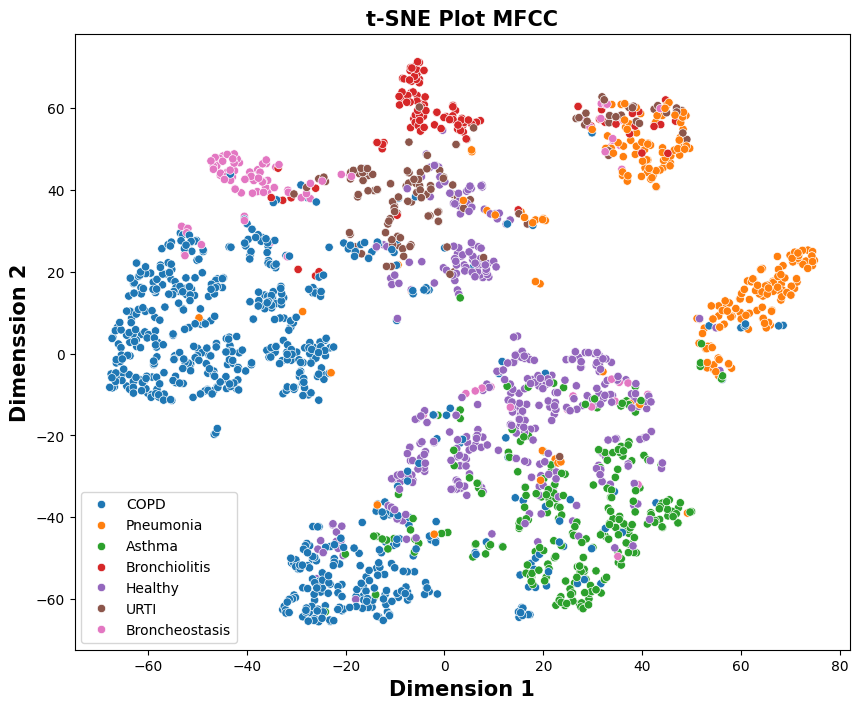

In [ ]:
import fastonn
from fastonn import SelfONN2d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt
Mfccs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Mfccs')
Mfccs_re=np.reshape(Mfccs,(Mfccs.shape[0],1,Mfccs.shape[1],Mfccs.shape[2]))

labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)

from sklearn.model_selection import train_test_split
def create_datasets(Xmel, Y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, y_train1, y_test = train_test_split(Xmel, Y, test_size=0.1,random_state=seed)

    Xmel_train, xmfcc_valid, y_train, y_valid = train_test_split(Xmel_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, xmfcc_valid,Xmel_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, xmfcc_valid,Xmel_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train, y_train)
    valid_ds = TensorDataset(xmfcc_valid, y_valid)
    test_ds= TensorDataset(Xmel_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
trn_ds, val_ds, tst_ds = create_datasets(Mfccs_re,Y,seed=10)
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, data):
        # mFCCtrogram scale
        x = self.onnv1(data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x_gap=self.GAP(x)

        x=self.flatten(x_gap)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)

PATH= "/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MFCC_model.pt"
model=torch.load(PATH)

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))
y_true = []
y_pred = []
FEATS=[]

for xmfcc_test, y_tst in (tst_dl):
    xmfcc_test=xmfcc_test.cuda()
    out_test = model(xmfcc_test)
    fea=activation['linear2'].data.cpu().numpy()
    FEATS.append(fea)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)

q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=20.0,learning_rate='auto',init='random',method="exact")
def scatter(x, labels):
    df = pd.DataFrame()
    df["Labels"] = labels
    df["comp-1"] = x[:,0]
    df["comp-2"] =x[:,1]
    plt.figure(figsize=(10,8))
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df)
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)

test_tsne_embeds = tsne.fit_transform(FEATS)
scatter(test_tsne_embeds,Label_ar)
plt.title('t-SNE Plot MFCC',fontweight ='bold', fontsize = 15)

np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MFCC_tsne_emds.txt',test_tsne_embeds)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/MFCC_tsne_labels.txt',Label_ar,'%s')

# **BA 3: CQT model**

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

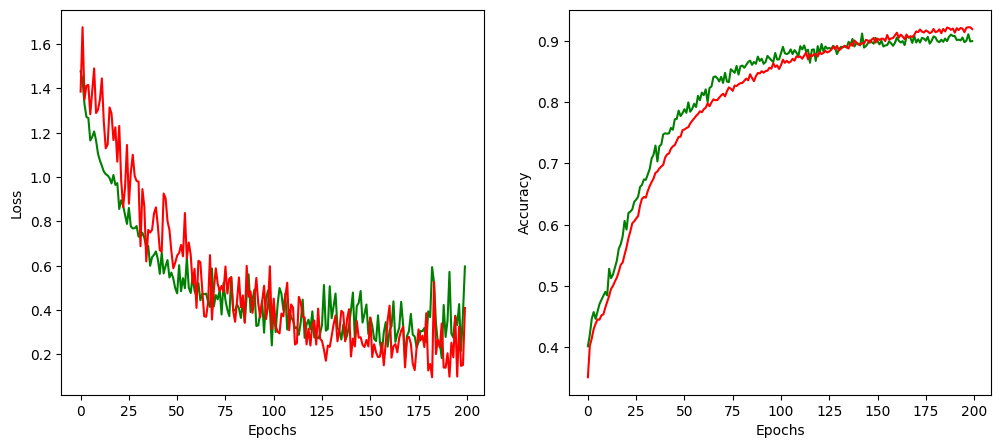

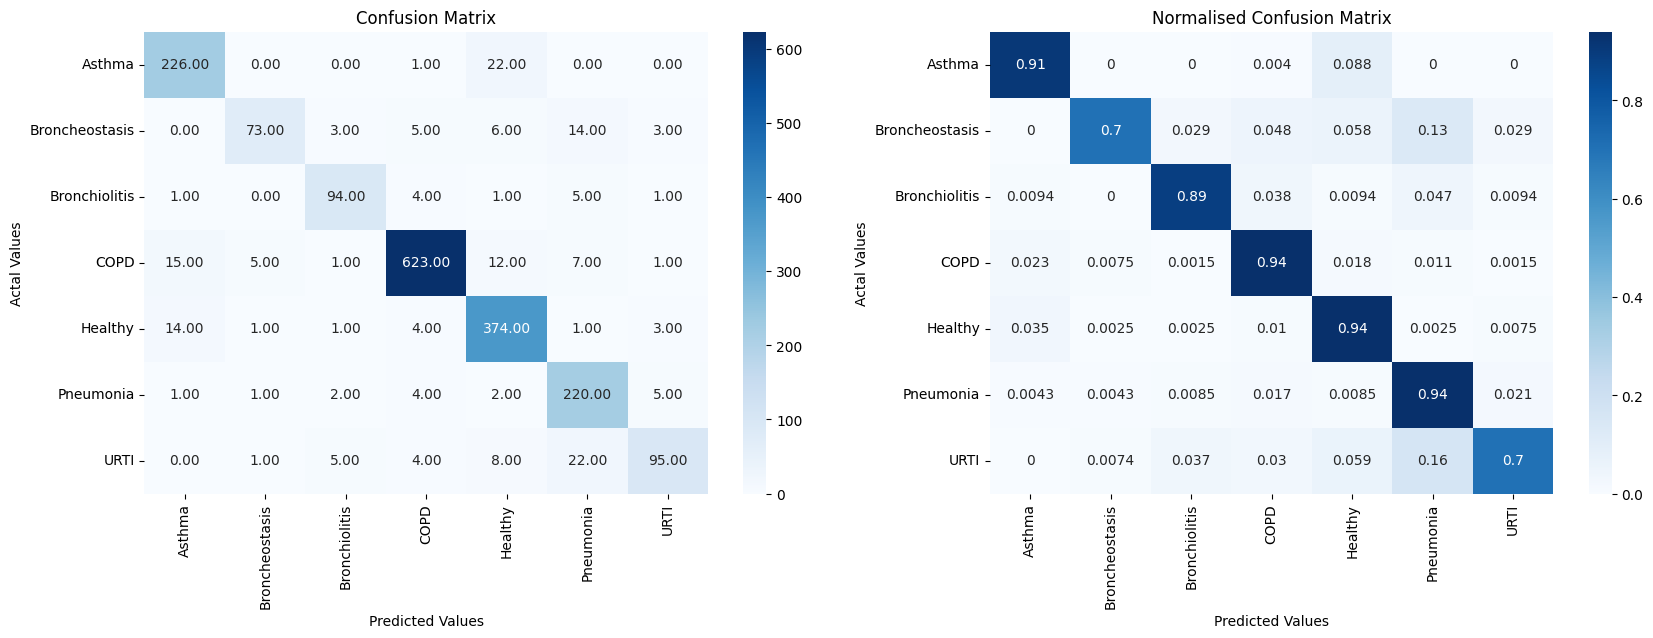

                precision    recall  f1-score   support

        Asthma       0.88      0.91      0.89       249
Broncheostasis       0.90      0.70      0.79       104
 Bronchiolitis       0.89      0.89      0.89       106
          COPD       0.97      0.94      0.95       664
       Healthy       0.88      0.94      0.91       398
     Pneumonia       0.82      0.94      0.87       235
          URTI       0.88      0.70      0.78       135

      accuracy                           0.90      1891
     macro avg       0.89      0.86      0.87      1891
  weighted avg       0.90      0.90      0.90      1891



In [ ]:
import fastonn
from fastonn import SelfONN2d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt
CQTs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/CQTs')
CQTs_re=np.reshape(CQTs,(CQTs.shape[0],1,CQTs.shape[1],CQTs.shape[2]))

labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)

from sklearn.model_selection import train_test_split
def create_datasets(Xmel, Y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, y_train1, y_test = train_test_split(Xmel, Y, test_size=0.1,random_state=seed)

    Xmel_train, x_cqt_valid, y_train, y_valid = train_test_split(Xmel_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, x_cqt_valid,Xmel_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, x_cqt_valid,Xmel_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train, y_train)
    valid_ds = TensorDataset(x_cqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
trn_ds, val_ds, tst_ds = create_datasets(CQTs_re,Y,seed=10)
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, data):
        # melspectrogram scale
        x = self.onnv1(data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x_gap=self.GAP(x)

        x=self.flatten(x_gap)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)


lr = 0.001
n_epochs = 200
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xcqt_batch = xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for x_cqt_val, y_val in (val_dl):
            x_cqt_val=x_cqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(x_cqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for xcqt_test, y_tst in (tst_dl):
    xcqt_test=xcqt_test.cuda()
    out_test = model(xcqt_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

from sklearn.metrics import classification_report
target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
print(classification_report(y_true,y_pred, target_names=target_names))

In [ ]:
PATH= '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/CQT_model.pt'
torch.save(model, PATH)
torch.save(model.state_dict(), '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/CQT_model.pth')
new_loc='/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/'
# save the plot varriables
filepath_tloss=new_loc+'/CQT_train_loss_fold.txt'; np.savetxt(filepath_tloss,train_loss)
filepath_vloss=new_loc+'/CQT_val_loss_fold.txt'; np.savetxt(filepath_vloss,val_loss)
filepath_tacc=new_loc+'/CQT_train_acc_fold.txt'; np.savetxt(filepath_tacc,train_acc)
filepath_vacc=new_loc+'/CQT_val_acc_fold.txt'; np.savetxt(filepath_vacc,val_acc)

Test accuracy is = 90.1639344262295%


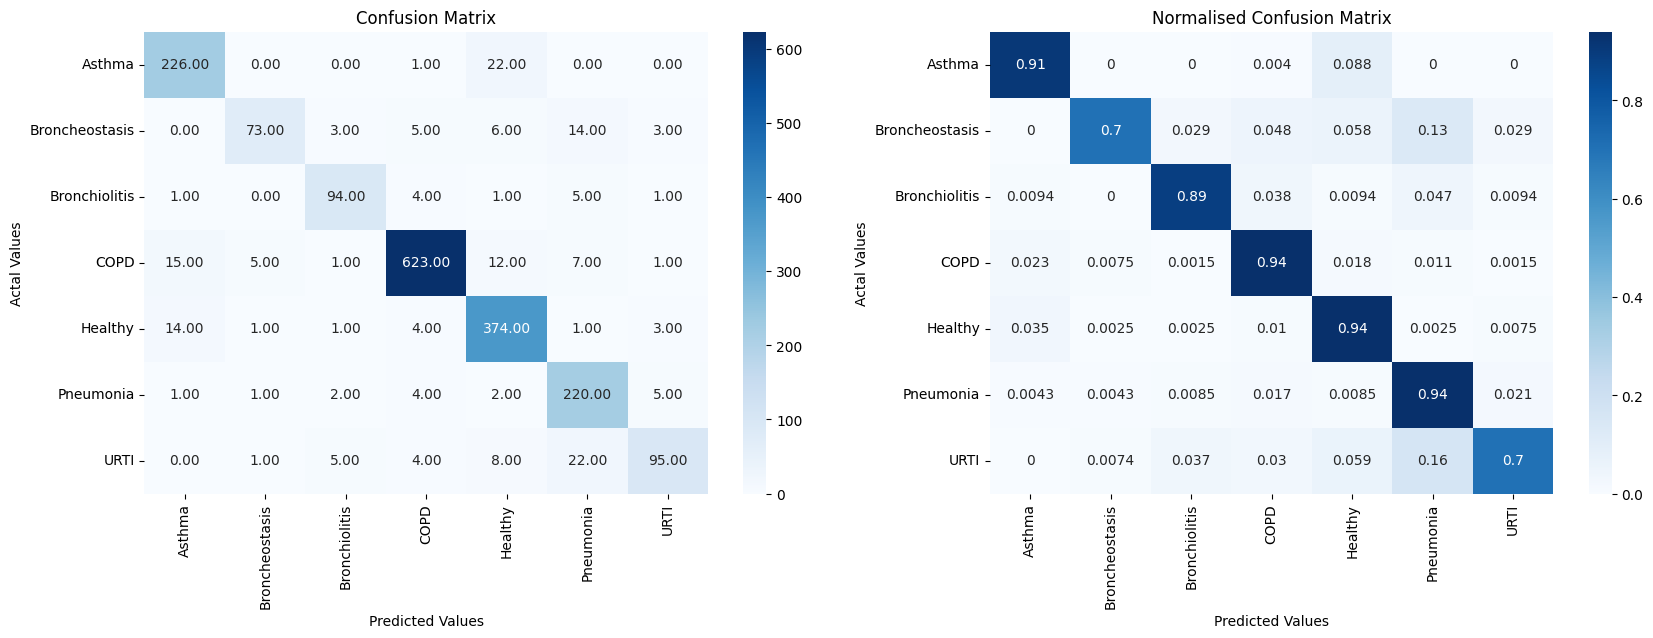

feats shape: (1891, 50)
label shape: (1891,)


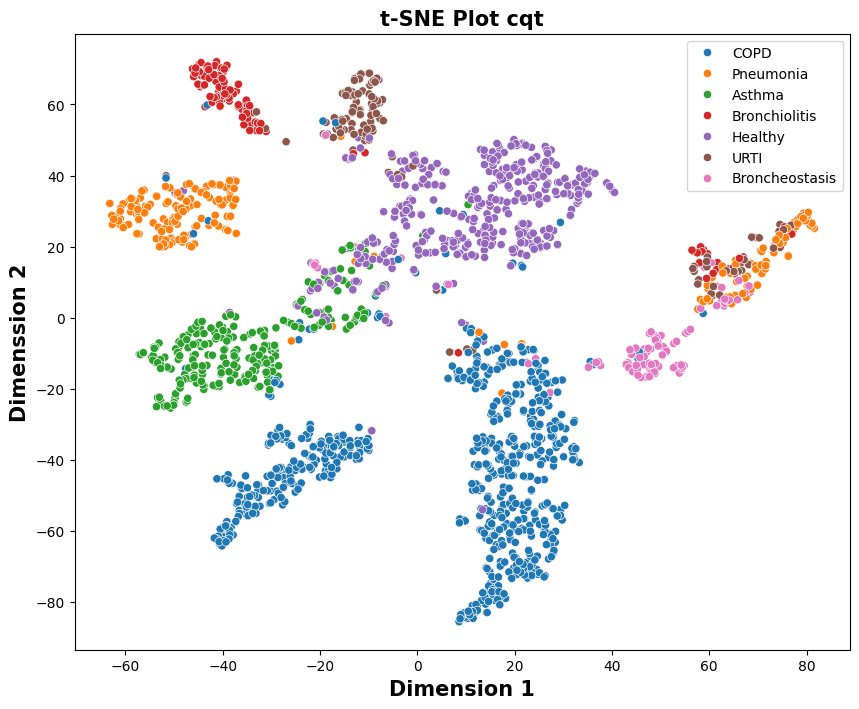

In [ ]:
import fastonn
from fastonn import SelfONN2d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt
CQTs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/CQTs')
CQTs_re=np.reshape(CQTs,(CQTs.shape[0],1,CQTs.shape[1],CQTs.shape[2]))

labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)

from sklearn.model_selection import train_test_split
def create_datasets(Xmel, Y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, y_train1, y_test = train_test_split(Xmel, Y, test_size=0.1,random_state=seed)

    Xmel_train, x_cqt_valid, y_train, y_valid = train_test_split(Xmel_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, x_cqt_valid,Xmel_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, x_cqt_valid,Xmel_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train, y_train)
    valid_ds = TensorDataset(x_cqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
trn_ds, val_ds, tst_ds = create_datasets(CQTs_re,Y,seed=10)
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, data):
        # melspectrogram scale
        x = self.onnv1(data)
        x = self.onnv2(x)
        x = self.onnv3(x)
        x_gap=self.GAP(x)

        x=self.flatten(x_gap)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)

PATH= "/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/CQT_model.pt"
model=torch.load(PATH)

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))
y_true = []
y_pred = []
FEATS=[]

for xcqt_test, y_tst in (tst_dl):
    xcqt_test=xcqt_test.cuda()
    out_test = model(xcqt_test)
    fea=activation['linear2'].data.cpu().numpy()
    FEATS.append(fea)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt='.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)

q=y_true
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=20.0,learning_rate='auto',init='random',method="exact")
def scatter(x, labels):
    df = pd.DataFrame()
    df["Labels"] = labels
    df["comp-1"] = x[:,0]
    df["comp-2"] =x[:,1]
    plt.figure(figsize=(10,8))
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df)
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)

test_tsne_embeds = tsne.fit_transform(FEATS)
scatter(test_tsne_embeds,Label_ar)
plt.title('t-SNE Plot cqt',fontweight ='bold', fontsize = 15)

np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/cqt_tsne_emds.txt',test_tsne_embeds)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/cqt_tsne_labels.txt',Label_ar,'%s')

# **BA 4: MFCC + CQT**

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmfcc,Xcqt, y, test_size=0.15,seed=None):
    Xmfcc_train1,Xmfcc_test,Xcqt_train1,Xcqt_test, y_train1, y_test = train_test_split(Xmfcc,Xcqt, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmfcc_train1,Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmfcc_test,Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmfcc_train, Xmfcc_valid,Xcqt_train, Xcqt_valid,Xmfcc_test,Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmfcc_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmfcc_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmfcc_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Mfccs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1891,)
Creating data loaders with batch size: 128


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 28, 38]             448
              Tanh-2           [-1, 16, 28, 38]               0
         MaxPool2d-3           [-1, 16, 14, 19]               0
         SelfONN2d-4           [-1, 32, 12, 17]          13,856
              Tanh-5           [-1, 32, 12, 17]               0
         MaxPool2d-6             [-1, 32, 6, 8]               0
         SelfONN2d-7            [-1, 128, 4, 6]         147,584
              Tanh-8            [-1, 128, 4, 6]               0
         MaxPool2d-9            [-1, 128, 2, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 62, 38]             448
             Tanh-12           [-1, 16, 62, 38]               0
        MaxPool2d-13           [-1, 16, 31, 19]               0
        SelfONN2d-14           [-1, 32,

(0.0, 1.0)

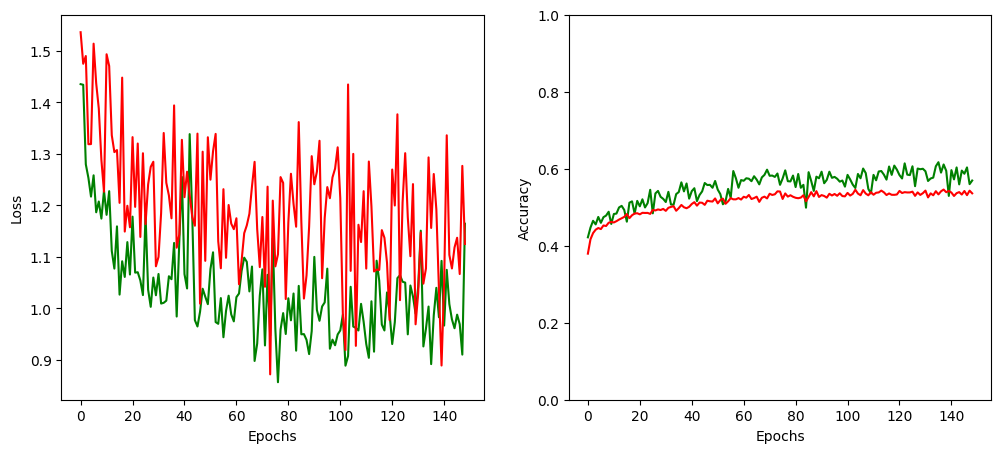

In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(2*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, mfcc_data, cqt_data):

        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)
        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat(( x_mfcc_flat,x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 30,40),(1, 64, 40)])
lr = 0.008
n_epochs = 149
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmfcc_batch,xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmfcc_batch,xcqt_batch = xmfcc_batch.cuda(),xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmfcc_batch,xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmfcc_val,xcqt_val, y_val in (val_dl):
            xmfcc_val,xcqt_val=xmfcc_val.cuda(),xcqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmfcc_val,xcqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)

Test accuracy is = 54.41565309360127%


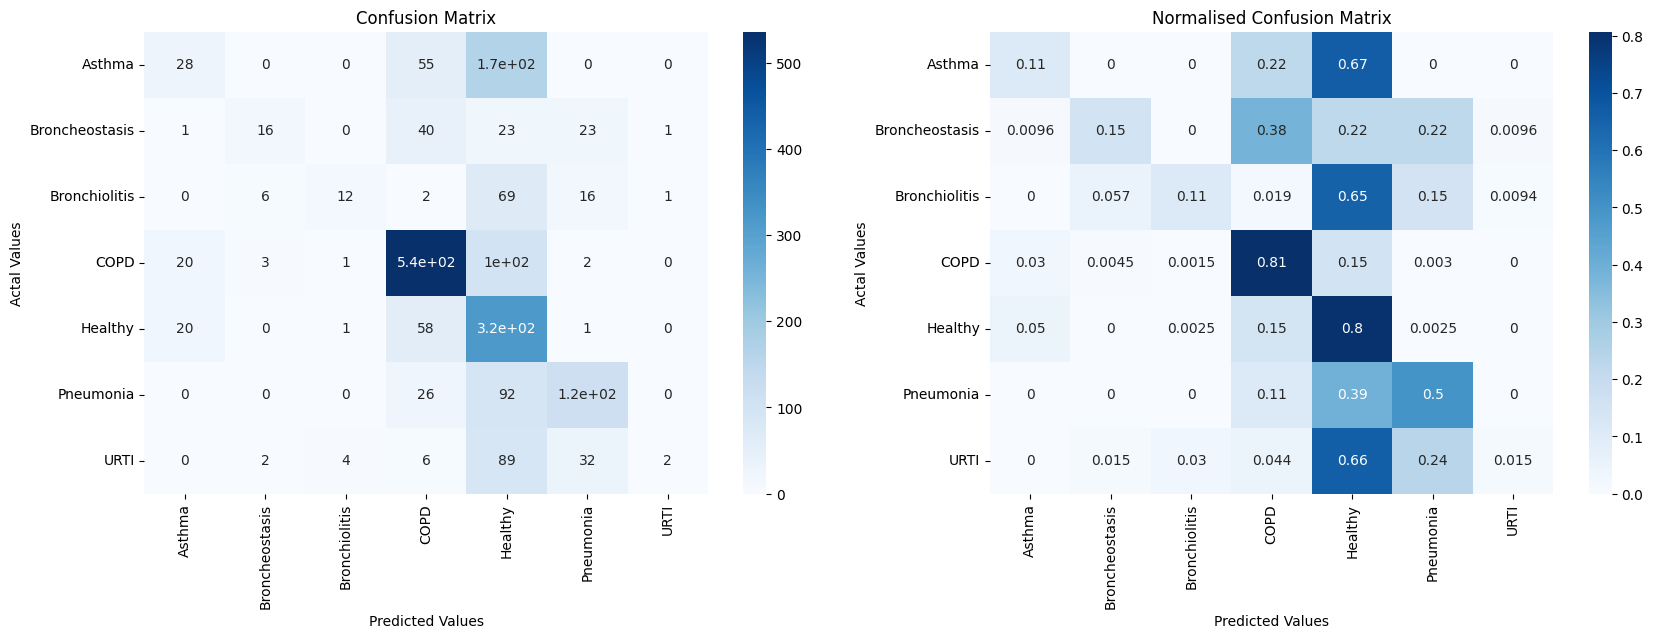

                precision    recall  f1-score   support

        Asthma       0.41      0.11      0.18       249
Broncheostasis       0.59      0.15      0.24       104
 Bronchiolitis       0.67      0.11      0.19       106
          COPD       0.74      0.81      0.77       664
       Healthy       0.37      0.80      0.51       398
     Pneumonia       0.61      0.50      0.55       235
          URTI       0.50      0.01      0.03       135

      accuracy                           0.54      1891
     macro avg       0.56      0.36      0.35      1891
  weighted avg       0.57      0.54      0.50      1891



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

#model.load_state_dict(torch.load('/content/gdrive/MyDrive/ARKA/Asthma_classification/ONN_Results/onn_scatter.pth'))
model.eval()
for xmfcc_test,xcqt_test, y_tst in (tst_dl):
    xmfcc_test,xcqt_test=xmfcc_test.cuda(),xcqt_test.cuda()
    out_test = model(xmfcc_test,xcqt_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

q=np.array(y_true)
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels,palette="deep")
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)

from sklearn.metrics import classification_report
target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
print(classification_report(y_true,y_pred, target_names=target_names))

feats shape: (1891, 50)
label shape: (1891,)


[Text(0.5, 1.0, 'T-SNE projection for test case DS2ONN Melspectrogram + MFCC')]

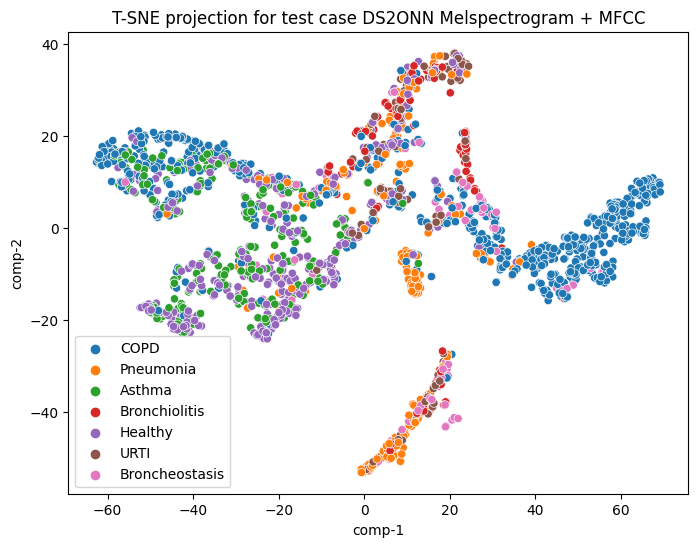

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))


FEATS = []
y_true = []
# placeholder for batch features
features = {}
for xmel_tst,xmfcc_tst,y_tst in tst_dl:
    xmel_tst,xmfcc_tst = xmel_tst.cuda(),xmfcc_tst.cuda()
    out = model(xmel_tst,xmfcc_tst)
    fea=activation['linear2'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)



Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case DS2ONN Melspectrogram + MFCC")

In [ ]:
new_loc='/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MFCCCQT_Results'
# save the plot varriables
filepath_tloss=new_loc+'/train_loss_specCQT_MFCC.txt'; np.savetxt(filepath_tloss,train_loss)
filepath_vloss=new_loc+'/val_loss_specCQT_MFCC.txt'; np.savetxt(filepath_vloss,val_loss)
filepath_tacc=new_loc+'/train_acc_specCQT_MFCC.txt'; np.savetxt(filepath_tacc,train_acc)
filepath_vacc=new_loc+'/val_acc_specCQT_MFCC.txt'; np.savetxt(filepath_vacc,val_acc)
PATH= '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MFCCCQT_Results/DS2ONN_MFCCCQT.pt'
#torch.save(model, PATH)
#torch.save(model.state_dict(), '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MFCCCQT_Results/DS2ONN_MFCCCQT.pth')


In [ ]:
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MFCCCQT_Results/DS2SONN_MFCCCQT_tsne_emds.txt',Y_embedded)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MFCCCQT_Results/DS2ONN_MFCCCQT_tsne_labels.txt',Label_ar,'%s')

# **BA-5: Melspectrogram + CQT**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Mounted at /content/gdrive


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
!git clone https://github.com/junaidmalik09/fastonn.git
%cd /content/fastonn
!pip install .
import fastonn
from fastonn import SelfONN2d

Cloning into 'fastonn'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 171 (delta 30), reused 71 (delta 11), pack-reused 70
Receiving objects: 100% (171/171), 555.71 KiB | 809.00 KiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/fastonn
Processing /content/fastonn
  Preparing metadata (setup.py) ... done
  Created wheel for fastonn: filename=fastonn-0.1.1-py3-none-any.whl size=299578 sha256=2d7e824c602757dead153d012e230469394313d0fc8452cad3e325ee8b2401ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-qirv2cls/wheels/61/8b/99/d8de1ae4507a27413aa8596d19e503645ccfdb3df60b239682
Successfully built fastonn


/content/fastonn/fastonn/utils/utils.py:347: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if val_rate is 0: return [[np.reshape(np.array([indices]),(len(indices),)),np.array([])]]


In [ ]:
import pickle
def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt

Melspecs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Melspecs')
Melspecs_re=np.reshape(Melspecs,(Melspecs.shape[0],1,Melspecs.shape[1],Melspecs.shape[2]))
Mfccs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/Mfccs')
Mfccs_re=np.reshape(Mfccs,(Mfccs.shape[0],1,Mfccs.shape[1],Mfccs.shape[2]))
CQTs= load_pickle_file('/content/gdrive/MyDrive/ARKA/7class_disease_work/CQTs')
CQTs_re=np.reshape(CQTs,(CQTs.shape[0],1,CQTs.shape[1],CQTs.shape[2]))

In [ ]:
print('shape of melspectrogram dataset'+str(np.shape(Melspecs_re)))
print('shape of mfcc dataset'+str(np.shape(Mfccs_re)))
print('shape of cqt dataset'+str(np.shape(CQTs_re)))

shape of melspectrogram dataset(18905, 1, 64, 39)
shape of mfcc dataset(18905, 1, 30, 40)
shape of cqt dataset(18905, 1, 64, 40)


In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/7class_disease_work/7class_labels.xlsx',header=None)
l=np.array(labels)
label_list=[]
for i in range (18905):
  if l[i]=='Asthma':
    label_list.append(0)
  elif l[i]=='Broncheostatis':
    label_list.append(1)
  elif l[i]=='Bronchiolitis':
    label_list.append(2)
  elif l[i]=='COPD':
    label_list.append(3)
  elif l[i]=='Healthy':
    label_list.append(4)
  elif l[i]=='Pneumonia':
    label_list.append(5)
  elif l[i]=='URTI':
    label_list.append(6)
Y=np.array(label_list)
Y.shape

(18905,)

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
import gc
torch.cuda.empty_cache()
gc.collect()

20315

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xcqt, y, test_size=0.1,seed=None):
    Xmel_train1, Xmel_test, Xcqt_train1, Xcqt_test, y_train1, y_test = train_test_split(Xmel, Xcqt, Y, test_size=0.1, random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid, Xcqt_train, Xcqt_valid, y_train, y_valid = train_test_split(Xmel_train1, Xcqt_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid, Xcqt_train, Xcqt_valid, Xmel_test, Xcqt_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid, Xcqt_train, Xcqt_valid, Xmel_test, Xcqt_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xcqt_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xcqt_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xcqt_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re,CQTs_re,Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(2*out_filter, 100)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(100, 7)


    def forward(self, melspec_data, cqt_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)

        # cqt scale
        x_cqt = self.onnv1(cqt_data)
        x_cqt = self.onnv2(x_cqt)
        x_cqt = self.onnv3(x_cqt)
        x_cqt_flat=self.GAP(x_cqt)

        x_concat = torch.cat((x_mel_flat, x_cqt_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 64, 40)])

Preparing datasets
(1891,)
Creating data loaders with batch size: 128
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 62, 38]             448
             Tanh-12           [-1, 16, 62, 38]               0
        MaxPool2d-13           [-

Start model training
Epoch:   1. Training Loss: 1.1108. Validation Loss: 0.9475. Training Acc.: 57.24%  Validation Acc.: 58.05%
Epoch:   2. Training Loss: 1.1958. Validation Loss: 0.8690. Training Acc.: 57.56%  Validation Acc.: 57.99%
Epoch:   3. Training Loss: 1.1676. Validation Loss: 0.8841. Training Acc.: 54.66%  Validation Acc.: 57.52%
Epoch:   4. Training Loss: 1.1082. Validation Loss: 0.9080. Training Acc.: 55.13%  Validation Acc.: 60.87%
Epoch:   5. Training Loss: 1.2261. Validation Loss: 1.0909. Training Acc.: 56.90%  Validation Acc.: 56.52%
Epoch:   6. Training Loss: 1.0460. Validation Loss: 0.8968. Training Acc.: 58.83%  Validation Acc.: 61.16%
Epoch:   7. Training Loss: 1.1094. Validation Loss: 0.8307. Training Acc.: 58.04%  Validation Acc.: 62.10%
Epoch:   8. Training Loss: 0.9055. Validation Loss: 0.7542. Training Acc.: 59.18%  Validation Acc.: 64.34%
Epoch:   9. Training Loss: 1.1550. Validation Loss: 0.7859. Training Acc.: 60.85%  Validation Acc.: 61.22%
Epoch:  10. Trai

(0.0, 1.0)

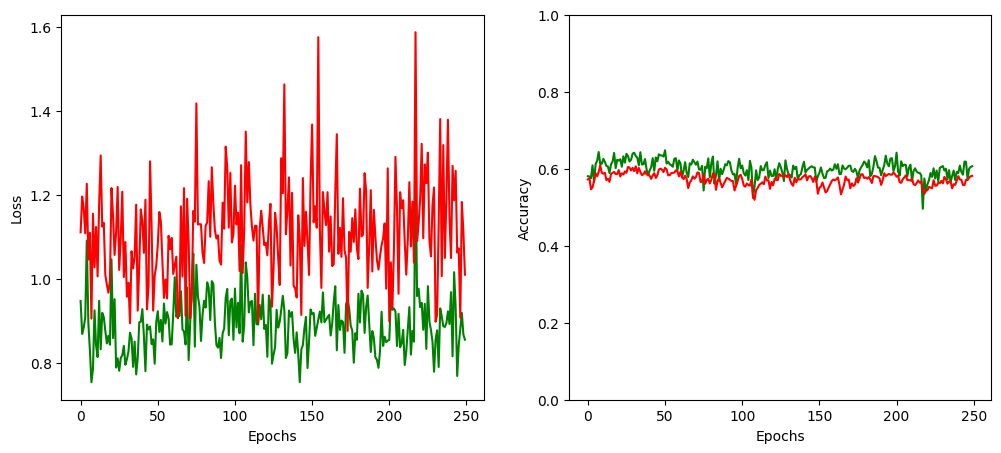

In [ ]:
lr = 0.008
n_epochs = 250
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch,xcqt_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch,xcqt_batch = xmel_batch.cuda(),xcqt_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch,xcqt_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val,xcqt_val, y_val in (val_dl):
            xmel_val,xcqt_val=xmel_val.cuda(),xcqt_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val,xcqt_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)

Test accuracy is = 59.862506610259125%


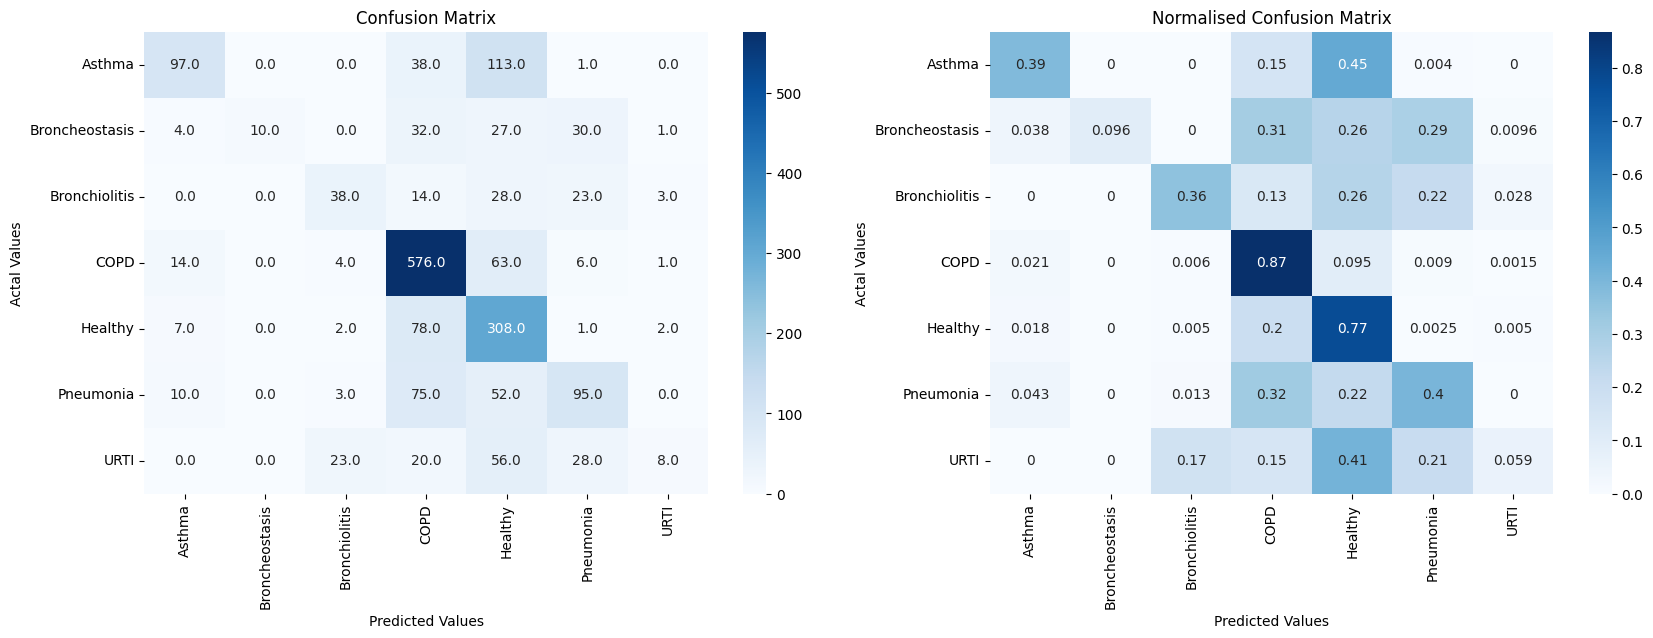

                precision    recall  f1-score   support

        Asthma       0.73      0.39      0.51       249
Broncheostasis       1.00      0.10      0.18       104
 Bronchiolitis       0.54      0.36      0.43       106
          COPD       0.69      0.87      0.77       664
       Healthy       0.48      0.77      0.59       398
     Pneumonia       0.52      0.40      0.45       235
          URTI       0.53      0.06      0.11       135

      accuracy                           0.60      1891
     macro avg       0.64      0.42      0.43      1891
  weighted avg       0.63      0.60      0.56      1891



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []


model.eval()
for xmel_test,xcqt_test, y_tst in (tst_dl):
    xmel_test,xcqt_test=xmel_test.cuda(),xcqt_test.cuda()
    out_test = model(xmel_test,xcqt_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues",fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


from sklearn.metrics import classification_report
target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
print(classification_report(y_true,y_pred, target_names=target_names))

feats shape: (1891, 100)
label shape: (1891,)


[Text(0.5, 1.0, 'T-SNE projection for test case DS2ONN Melspectrogram + MFCC')]

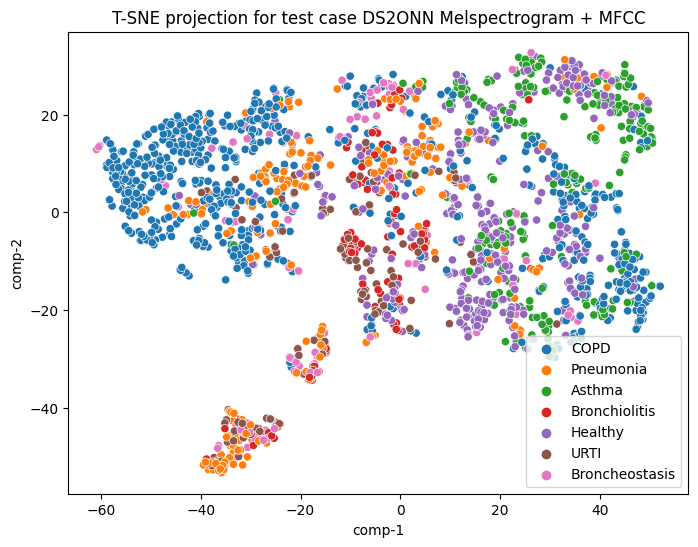

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear1.register_forward_hook(get_activation('linear1'))


FEATS = []
y_true = []
# placeholder for batch features
features = {}
for xmel_tst,xmfcc_tst,y_tst in tst_dl:
    xmel_tst,xmfcc_tst = xmel_tst.cuda(),xmfcc_tst.cuda()
    out = model(xmel_tst,xmfcc_tst)
    fea=activation['linear1'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)



Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case DS2ONN Melspectrogram + MFCC")

In [ ]:
new_loc='/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelCQT_Results'
# save the plot varriables
filepath_tloss=new_loc+'/train_loss_melspec_cqt.txt'; np.savetxt(filepath_tloss,train_loss)
filepath_vloss=new_loc+'/val_loss_melspec_cqt.txt'; np.savetxt(filepath_vloss,val_loss)
filepath_tacc=new_loc+'/train_acc_melspec_cqt.txt'; np.savetxt(filepath_tacc,train_acc)
filepath_vacc=new_loc+'/val_acc_melspec_cqt.txt'; np.savetxt(filepath_vacc,val_acc)
PATH= '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelCQT_Results/DS2ONN_melcqt.pt'
# torch.save(model, PATH)
# torch.save(model.state_dict(), '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelCQT_Results/DS2ONN_melcqt.pth')

In [ ]:
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelCQT_Results/DS2SONN_MelCQT_tsne_emds.txt',Y_embedded_mel_cqt)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelCQT_Results/DS2ONN_MelCQT_tsne_labels.txt',Label_ar,'%s')

# **BA-6: Melspectrogram + MFCC**

In [ ]:
from sklearn.model_selection import train_test_split
def create_datasets(Xmel,Xmfcc, y, test_size=0.15,seed=None):
    Xmel_train1, Xmel_test, Xmfcc_train1,Xmfcc_test, y_train1, y_test = train_test_split(Xmel,Xmfcc, Y, test_size=0.1,random_state=seed)
    print(y_test.shape)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid, y_train, y_valid = train_test_split(Xmel_train1, Xmfcc_train1, y_train1, test_size=0.1,random_state=seed)
    Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid, Xmel_test, Xmfcc_test = [torch.tensor(arr, dtype=torch.float32) for arr in (Xmel_train, Xmel_valid,Xmfcc_train, Xmfcc_valid, Xmel_test, Xmfcc_test)]
    y_train, y_valid, y_test = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid, y_test)]

    train_ds = TensorDataset(Xmel_train,Xmfcc_train, y_train)
    valid_ds = TensorDataset(Xmel_valid,Xmfcc_valid, y_valid)
    test_ds= TensorDataset(Xmel_test,Xmfcc_test, y_test)
    return train_ds, valid_ds, test_ds
def create_loaders(train_ds, valid_ds, test_ds, bs, jobs=2):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl,test_dl
bs = 128
print('Preparing datasets')
trn_ds, val_ds, tst_ds = create_datasets(Melspecs_re, Mfccs_re, Y,seed=10)
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl,tst_dl = create_loaders(trn_ds, val_ds,tst_ds, bs)

Preparing datasets
(1891,)
Creating data loaders with batch size: 128


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         SelfONN2d-1           [-1, 16, 62, 37]             448
              Tanh-2           [-1, 16, 62, 37]               0
         MaxPool2d-3           [-1, 16, 31, 18]               0
         SelfONN2d-4           [-1, 32, 29, 16]          13,856
              Tanh-5           [-1, 32, 29, 16]               0
         MaxPool2d-6            [-1, 32, 14, 8]               0
         SelfONN2d-7           [-1, 128, 12, 6]         147,584
              Tanh-8           [-1, 128, 12, 6]               0
         MaxPool2d-9            [-1, 128, 6, 3]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
        SelfONN2d-11           [-1, 16, 28, 38]             448
             Tanh-12           [-1, 16, 28, 38]               0
        MaxPool2d-13           [-1, 16, 14, 19]               0
        SelfONN2d-14           [-1, 32,

(0.0, 1.0)

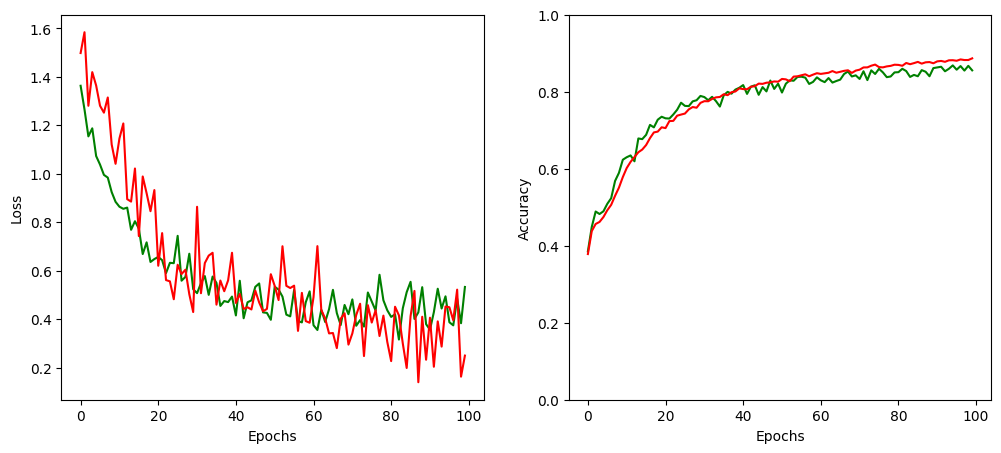

In [ ]:
from torch import nn
from torchsummary import summary
out_filter=128
class ONNNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.onnv1 = nn.Sequential(
            SelfONN2d(in_channels=1,out_channels=16,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.onnv2 = nn.Sequential(
            SelfONN2d(in_channels=16,out_channels=32,kernel_size=3,q=3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.onnv3 = nn.Sequential(
            SelfONN2d(in_channels=32,out_channels=out_filter,kernel_size=3,q=4),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.GAP=nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(2*out_filter, 100)
        self.linear2 = nn.Linear(100, 50)
        self.gelu=nn.GELU()
        self.relu=nn.ReLU()
        self.dropout =nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(50, 7)


    def forward(self, melspec_data, mfcc_data):
        # melspectrogram scale
        x_mel = self.onnv1(melspec_data)
        x_mel = self.onnv2(x_mel)
        x_mel = self.onnv3(x_mel)
        x_mel_flat=self.GAP(x_mel)
        # mfcc scale
        x_mfcc = self.onnv1(mfcc_data)
        x_mfcc = self.onnv2(x_mfcc)
        x_mfcc = self.onnv3(x_mfcc)
        x_mfcc_flat=self.GAP(x_mfcc)


        x_concat = torch.cat((x_mel_flat, x_mfcc_flat), dim=1)
        x=self.flatten(x_concat)
        x = self.dropout(x)
        x=self.relu(x)
        x = self.linear1(x)
        x=self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x=self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ONNNetwork().to(device)
summary(model, [(1, 64, 39),(1, 30,40)])
lr = 0.003
n_epochs = 100
iterations_per_epoch = len(trn_dl)

trainloss_history = []
valacc_history = []
valloss_history = []
trainacc_history=[]
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)


print('Start model training')

for epoch in range(1, n_epochs + 1):
    correct, total = 0, 0
    for i, (xmel_batch,xmfcc_batch, y_batch) in enumerate(trn_dl):
        model.train()
        xmel_batch,xmfcc_batch = xmel_batch.cuda(),xmfcc_batch.cuda()
        y_batch = y_batch.cuda()
        opt.zero_grad()
        out_tr = model(xmel_batch,xmfcc_batch)
        loss =  criterion(out_tr, y_batch)
        preds_tr = F.log_softmax(out_tr, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds_tr == y_batch).sum().item()
        loss.backward()
        opt.step()
    trainloss_history.append(loss)
    train_acc = correct / total
    trainacc_history.append(train_acc)
    with torch.no_grad():
        model.eval()
        correct, total = 0, 0
        for xmel_val,xmfcc_val, y_val in (val_dl):
            xmel_val,xmfcc_val=xmel_val.cuda(),xmfcc_val.cuda()
            y_val = y_val.cuda()
            out_vl = model(xmel_val,xmfcc_val)
            valid_loss = criterion(out_vl, y_val)
            preds = F.log_softmax(out_vl, dim=1).argmax(dim=1)
            total += y_val.size(0)
            correct += (preds == y_val).sum().item()
    valloss_history.append(valid_loss)
    valid_acc = correct / total
    valacc_history.append(valid_acc)
    print(f'Epoch: {epoch:3d}. Training Loss: {loss:.4f}. Validation Loss: {valid_loss:.4f}. Training Acc.: {train_acc:2.2%}  Validation Acc.: {valid_acc:2.2%}')

val_loss=torch.tensor(valloss_history,device = 'cpu'); val_loss_np=val_loss.numpy()
train_loss=torch.tensor(trainloss_history,device = 'cpu');train_loss_np=train_loss.numpy()
train_acc=torch.tensor(trainacc_history,device = 'cpu');train_acc_np=train_acc.numpy()
val_acc=torch.tensor(valacc_history,device = 'cpu'); val_acc_np=np.array(val_acc)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(val_loss_np,'g');plt.plot(train_loss_np,'r');
plt.ylabel('Loss');plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(val_acc_np,'g');plt.plot(train_acc_np,'r');
plt.ylabel('Accuracy');plt.xlabel('Epochs')
plt.ylim(0,1)



Test accuracy is = 83.50079323109466%


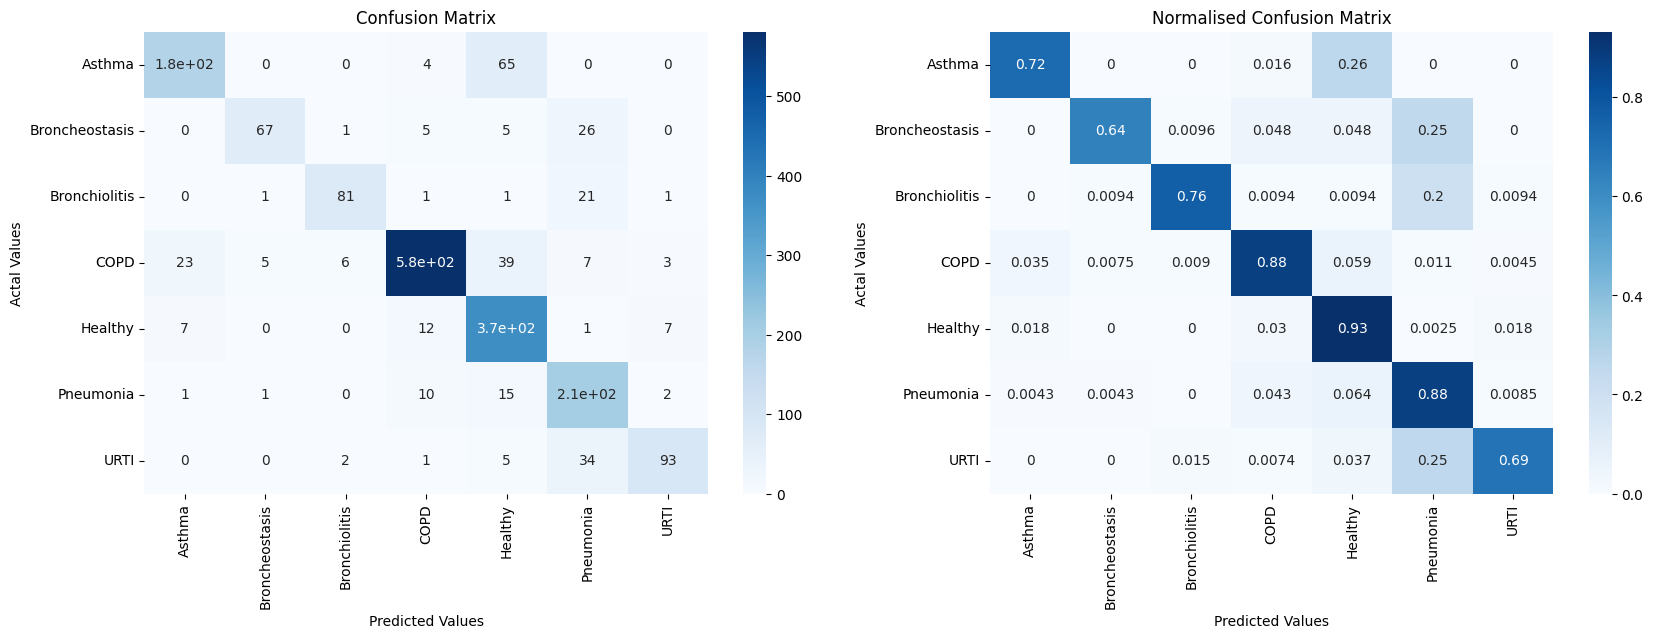

                precision    recall  f1-score   support

        Asthma       0.85      0.72      0.78       249
Broncheostasis       0.91      0.64      0.75       104
 Bronchiolitis       0.90      0.76      0.83       106
          COPD       0.95      0.88      0.91       664
       Healthy       0.74      0.93      0.83       398
     Pneumonia       0.70      0.88      0.78       235
          URTI       0.88      0.69      0.77       135

      accuracy                           0.84      1891
     macro avg       0.85      0.79      0.81      1891
  weighted avg       0.85      0.84      0.84      1891



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred = []

model.eval()
for xmel_test,xmfcc_test, y_tst in (tst_dl):
    xmel_test,xmfcc_test=xmel_test.cuda(),xmfcc_test.cuda()
    out_test = model(xmel_test,xmfcc_test)
    y_hat = F.log_softmax(out_test, dim=1).argmax(dim=1)
    y_hat=y_hat.data.cpu().numpy()
    y_pred.extend(y_hat) # Save preds

    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth


from sklearn.metrics import confusion_matrix
import seaborn as sns;
cm=confusion_matrix(y_true,y_pred)
Acc=cm.trace()/np.sum(cm)
print('Test accuracy is = '+str(Acc*100)+'%')
cm_norm=confusion_matrix(y_true,y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                     columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

q=np.array(y_true)
label_l=[]
for i in range (q.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)
import seaborn as sns;
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels,palette="deep")
    plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)

from sklearn.metrics import classification_report
target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
print(classification_report(y_true,y_pred, target_names=target_names))

feats shape: (1891, 50)
label shape: (1891,)


[Text(0.5, 1.0, 'T-SNE projection for test case DS2ONN Melspectrogram + MFCC')]

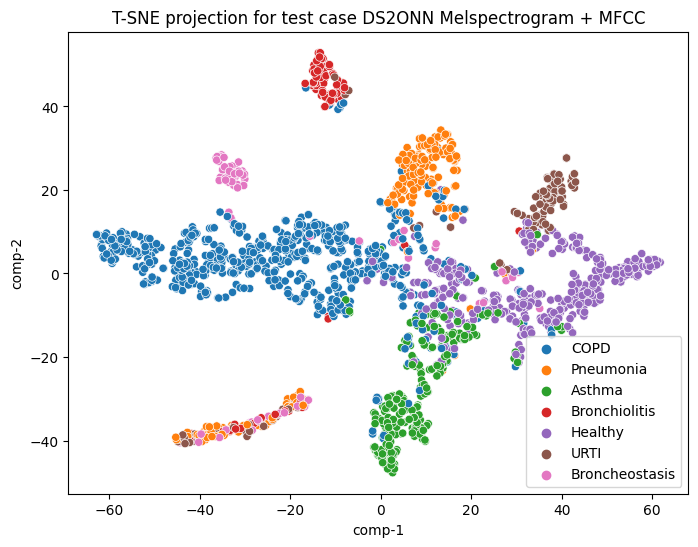

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear2.register_forward_hook(get_activation('linear2'))


FEATS = []
y_true = []
# placeholder for batch features
features = {}
for xmel_tst,xmfcc_tst,y_tst in tst_dl:
    xmel_tst,xmfcc_tst = xmel_tst.cuda(),xmfcc_tst.cuda()
    out = model(xmel_tst,xmfcc_tst)
    fea=activation['linear2'].data.cpu().numpy()
    #print('feature tensor shape:',fea.shape)
    FEATS.append(fea)
    y_tst = y_tst.data.cpu().numpy()
    y_true.extend(y_tst) # Save Truth

FEATS = np.concatenate(FEATS)
y_true=np.array(y_true)
print('feats shape:', FEATS.shape)
print('label shape:', y_true.shape)



Y_embedded = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection for test case DS2ONN Melspectrogram + MFCC")

In [ ]:
new_loc='/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results'
# save the plot varriables
filepath_tloss=new_loc+'/train_loss_melspec_MFCC.txt'; np.savetxt(filepath_tloss,train_loss)
filepath_vloss=new_loc+'/val_loss_melspec_MFCC.txt'; np.savetxt(filepath_vloss,val_loss)
filepath_tacc=new_loc+'/train_acc_melspec_MFCC.txt'; np.savetxt(filepath_tacc,train_acc)
filepath_vacc=new_loc+'/val_acc_melspec_MFCC.txt'; np.savetxt(filepath_vacc,val_acc)
PATH= '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results/DS2ONN_melMFCC.pt'
# torch.save(model, PATH)
# torch.save(model.state_dict(), '/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results/DS2ONN_melMFCC.pth')

np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results/DS2SONN_MelMFCC_tsne_emds.txt',Y_embedded)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results/DS2ONN_MelMFCC_tsne_labels.txt',Label_ar,'%s')

In [ ]:
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results/DS2SONN_MelMFCC_tsne_emds.txt',Y_embedded)
np.savetxt('/content/gdrive/MyDrive/ARKA/7class_disease_work/MSONN_results/DualStream_MelMFCC_Results/DS2ONN_MelMFCC_tsne_labels.txt',Label_ar,'%s')